In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Grid generation

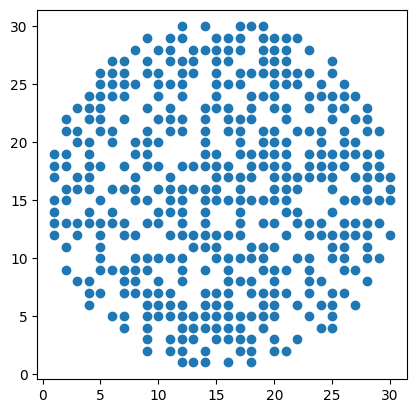

In [2]:
from collab2.foraging.toolkit import get_grid


def circular_constraint_func(x, y, R, c_x, c_y):
    return ((x - c_x) ** 2 + (y - c_y) ** 2) < R**2


grid_size = 30
grid = get_grid(
    grid_size=grid_size,
    sampling_fraction=0.5,
    grid_constraint=circular_constraint_func,
    grid_constraint_params={
        "c_x": grid_size / 2 + 0.5,
        "c_y": grid_size / 2 + 0.5,
        "R": grid_size / 2,
    },
)
fig, ax = plt.subplots()
ax.scatter(grid["x"], grid["y"])
ax.set_aspect("equal")

# Local windows

In [3]:
from collab2.foraging.toolkit import (
    _generate_local_windows,
    dataObject,
    rescale_to_grid,
    subset_frames_evenly_spaced,
)

num_frames = 10
num_foragers = 3

np.random.seed(42)

data = {
    "x": np.random.randn(num_frames * num_foragers),
    "y": np.random.randn(num_frames * num_foragers),
    "time": np.tile(np.arange(num_frames), num_foragers),
    "forager": np.concatenate([i * np.ones(num_frames) for i in range(num_foragers)]),
}
foragersDF = pd.DataFrame(data)

# add nan values
nan_ind = [4, 9, 20]
foragersDF.loc[nan_ind, ["x", "y"]] = np.nan

# remove values for certain time points
drop_ind = [12, 6, 14]
drop_t = foragersDF["time"][drop_ind].to_list()
drop_f = foragersDF["forager"][drop_ind].to_list()
foragersDF = foragersDF.drop(drop_ind)

# scaling and subsampling
foragersDF_scaled = rescale_to_grid(foragersDF, size=30)
foragersDF_scaled_subsampled = subset_frames_evenly_spaced(foragersDF_scaled, 8)
foragers_object = dataObject(foragersDF_scaled_subsampled)

local_windows_params = {
    "foragers": foragers_object.foragers,
    "grid_size": foragers_object.grid_size,
    "num_frames": foragers_object.num_frames,
    "num_foragers": foragers_object.num_foragers,
    "window_size": 10,
    "sampling_fraction": 0.5,
    "skip_incomplete_frames": False,
    "grid_constraint": None,
    "grid_constraint_params": None,
}
local_windows_no_constraint = _generate_local_windows(**local_windows_params)

original_frames: 9
original_shape: (27, 4)
resulting_frames: 8
resulting_shape: (22, 4)
min_time 1
max_time 8


/Users/Admin/Repositories/collab-creatures/collab2/foraging/toolkit/utils.py:36: UserWarning: Nan values in data. Specify handling of missing data using skip_incomplete_frames argument to generate_all_predictors
  warnings.warn(f"Nan values in data. Specify handling of missing data using skip_incomplete_frames argument to generate_all_predictors")
/Users/Admin/Repositories/collab-creatures/collab2/foraging/toolkit/utils.py:44: UserWarning: Incomplete frames in data. Specify handling of missing data using skip_incomplete_frames argument to generate_all_predictors
  warnings.warn(f"Incomplete frames in data. Specify handling of missing data using skip_incomplete_frames argument to generate_all_predictors")


In [4]:
def plot_local_windows(foragers_object, local_windows):
    ncols = 4
    nrows = np.ceil(foragers_object.num_frames / ncols).astype(int)
    fig, ax = plt.subplots(nrows, ncols, figsize=(10, 5))

    random_colors = np.random.randint(0, 256, size=(foragers_object.num_foragers, 3))
    # Convert the RGB values to hex format
    colors = ["#{:02x}{:02x}{:02x}".format(r, g, b) for r, g, b in random_colors]

    for t in range(foragers_object.num_frames):
        r = t // ncols
        c = t % ncols
        for f in range(foragers_object.num_foragers):
            if local_windows[f][t] is not None:
                ax[r, c].scatter(
                    local_windows[f][t]["x"],
                    local_windows[f][t]["y"],
                    s=0.3,
                    color=colors[f],
                )
            ax[r, c].scatter(
                foragers_object.foragers[f].query("time == @t+1")["x"],
                foragers_object.foragers[f].query("time == @t+1")["y"],
                s=10,
                color=colors[f],
            )

        ax[r, c].set_xlim([0, foragers_object.grid_size])
        ax[r, c].set_ylim([0, foragers_object.grid_size])
        ax[r, c].set_title(f"t={t+1}")
        ax[r, c].set_aspect("equal")

    fig.tight_layout(pad=2)
    return fig, ax

(<Figure size 1000x500 with 8 Axes>,
 array([[<Axes: title={'center': 't=1'}>, <Axes: title={'center': 't=2'}>,
         <Axes: title={'center': 't=3'}>, <Axes: title={'center': 't=4'}>],
        [<Axes: title={'center': 't=5'}>, <Axes: title={'center': 't=6'}>,
         <Axes: title={'center': 't=7'}>, <Axes: title={'center': 't=8'}>]],
       dtype=object))

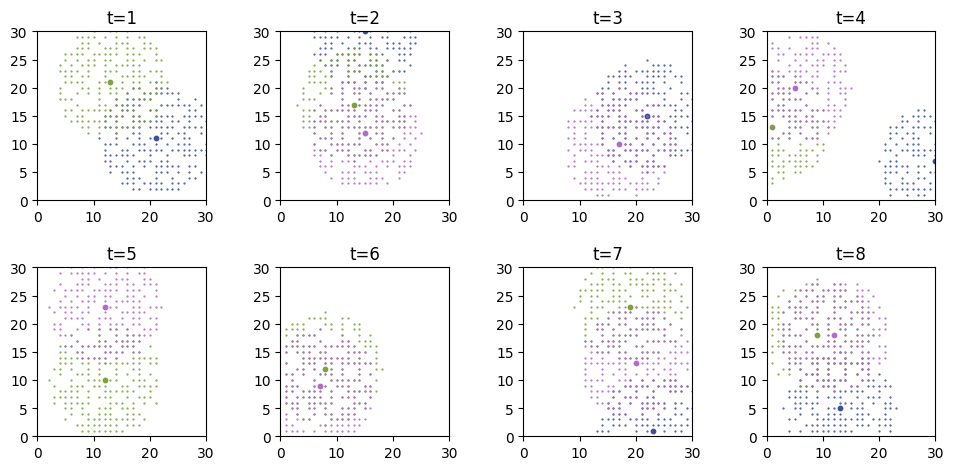

In [5]:
# check that frames with missing data have no local windows, as required
plot_local_windows(foragers_object, local_windows_no_constraint)

original_frames: 9
original_shape: (27, 4)
resulting_frames: 8
resulting_shape: (22, 4)
min_time 1
max_time 8


/Users/Admin/Repositories/collab-creatures/collab2/foraging/toolkit/utils.py:36: UserWarning: Nan values in data. Specify handling of missing data using skip_incomplete_frames argument to generate_all_predictors
  warnings.warn(f"Nan values in data. Specify handling of missing data using skip_incomplete_frames argument to generate_all_predictors")
/Users/Admin/Repositories/collab-creatures/collab2/foraging/toolkit/utils.py:44: UserWarning: Incomplete frames in data. Specify handling of missing data using skip_incomplete_frames argument to generate_all_predictors
  warnings.warn(f"Incomplete frames in data. Specify handling of missing data using skip_incomplete_frames argument to generate_all_predictors")


(<Figure size 1000x500 with 8 Axes>,
 array([[<Axes: title={'center': 't=1'}>, <Axes: title={'center': 't=2'}>,
         <Axes: title={'center': 't=3'}>, <Axes: title={'center': 't=4'}>],
        [<Axes: title={'center': 't=5'}>, <Axes: title={'center': 't=6'}>,
         <Axes: title={'center': 't=7'}>, <Axes: title={'center': 't=8'}>]],
       dtype=object))

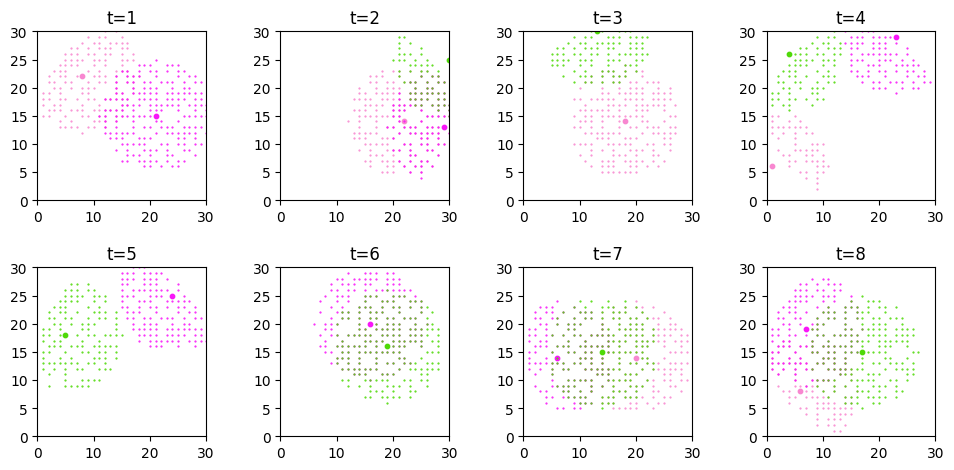

In [6]:
# including a constraint

num_frames = 10
num_foragers = 3
grid_size = 30

np.random.seed(42)
theta = 2 * np.pi * np.random.rand(num_frames * num_foragers)
r = grid_size / 2 * np.random.rand(num_frames * num_foragers)

data = {
    "x": r * np.cos(theta),
    "y": r * np.sin(theta),
    "time": np.tile(np.arange(num_frames), num_foragers),
    "forager": np.concatenate([i * np.ones(num_frames) for i in range(num_foragers)]),
}
foragersDF = pd.DataFrame(data)

# add nan values
nan_ind = [4, 9, 20]
foragersDF.loc[nan_ind, ["x", "y"]] = np.nan

# remove values for certain time points
drop_ind = [12, 6, 14]
drop_t = foragersDF["time"][drop_ind].to_list()
drop_f = foragersDF["forager"][drop_ind].to_list()
foragersDF = foragersDF.drop(drop_ind)

# scaling and subsampling
foragersDF_scaled = rescale_to_grid(foragersDF, size=30)
foragersDF_scaled_subsampled = subset_frames_evenly_spaced(foragersDF_scaled, 8)
foragers_object = dataObject(foragersDF_scaled_subsampled)

local_windows_params = {
    "foragers": foragers_object.foragers,
    "grid_size": foragers_object.grid_size,
    "num_frames": foragers_object.num_frames,
    "num_foragers": foragers_object.num_foragers,
    "window_size": 10,
    "sampling_fraction": 0.5,
    "skip_incomplete_frames": False,
    "grid_constraint": circular_constraint_func,
    "grid_constraint_params": {
        "c_x": grid_size / 2 + 0.5,
        "c_y": grid_size / 2 + 0.5,
        "R": grid_size / 2,
    },
}
local_windows_w_constraint = _generate_local_windows(**local_windows_params)
plot_local_windows(foragers_object, local_windows_w_constraint)

(<Figure size 1000x500 with 8 Axes>,
 array([[<Axes: title={'center': 't=1'}>, <Axes: title={'center': 't=2'}>,
         <Axes: title={'center': 't=3'}>, <Axes: title={'center': 't=4'}>],
        [<Axes: title={'center': 't=5'}>, <Axes: title={'center': 't=6'}>,
         <Axes: title={'center': 't=7'}>, <Axes: title={'center': 't=8'}>]],
       dtype=object))

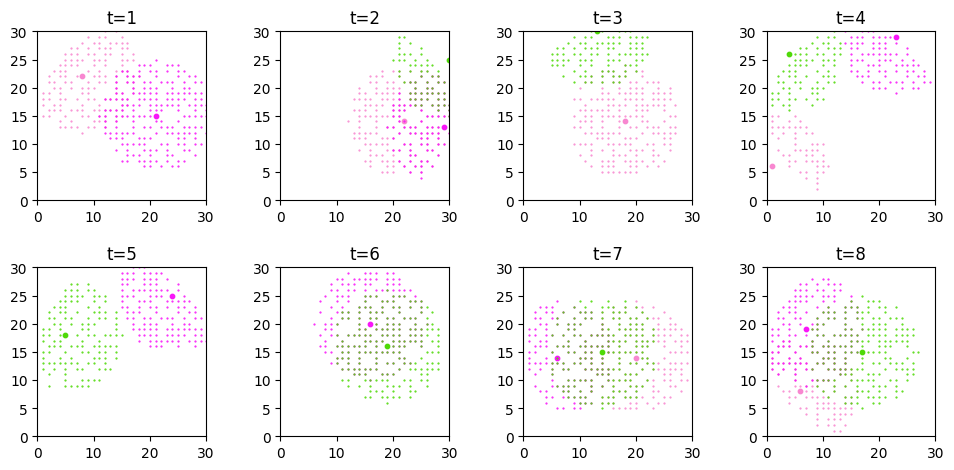

In [7]:
# check non-underscored (exposed) function
from collab2.foraging.toolkit import generate_local_windows

local_windows_kwargs = {
    "window_size": 10,
    "sampling_fraction": 0.5,
    "skip_incomplete_frames": False,
    "grid_constraint": circular_constraint_func,
    "grid_constraint_params": {
        "c_x": grid_size / 2 + 0.5,
        "c_y": grid_size / 2 + 0.5,
        "R": grid_size / 2,
    },
}

foragers_object.local_windows_kwargs = local_windows_kwargs

local_windows_w_constraint_2 = generate_local_windows(foragers_object)

plot_local_windows(foragers_object, local_windows_w_constraint_2)